In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,2,2,10,1946,2,0,88,1,88,88,...,1,1,1,0,0,0,72,33,891,True
1,1,8,5,1931,1,0,88,1,88,88,...,0,1,1,0,0,0,88,43,1304,True
2,2,2,1,1924,2,0,88,1,88,88,...,1,1,1,0,0,0,90,67,702,True
3,1,2,9,1934,2,0,88,1,88,88,...,1,1,1,1,1,0,84,4,379,True
4,1,8,10,1942,2,0,88,1,88,88,...,0,1,1,1,0,0,76,53,1099,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,1,1,11,1938,2,0,88,1,88,88,...,1,1,1,0,0,0,76,2,2733,True
348,1,1,5,1951,1,0,88,1,88,88,...,0,1,1,1,0,0,68,36,2539,False
349,1,2,5,1954,2,0,88,1,88,88,...,1,1,1,0,0,0,66,91,1127,False
350,2,2,7,1924,2,0,88,1,3,88,...,1,1,1,0,0,0,96,3,417,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

38.92% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=10
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 514.53
% Completion: 100%|***********************************************|Loss: 569.56
% Completion: 100%|***********************************************|Loss: 506.76
% Completion: 100%|***********************************************|Loss: 555.42
% Completion: 100%|***********************************************|Loss: 524.57


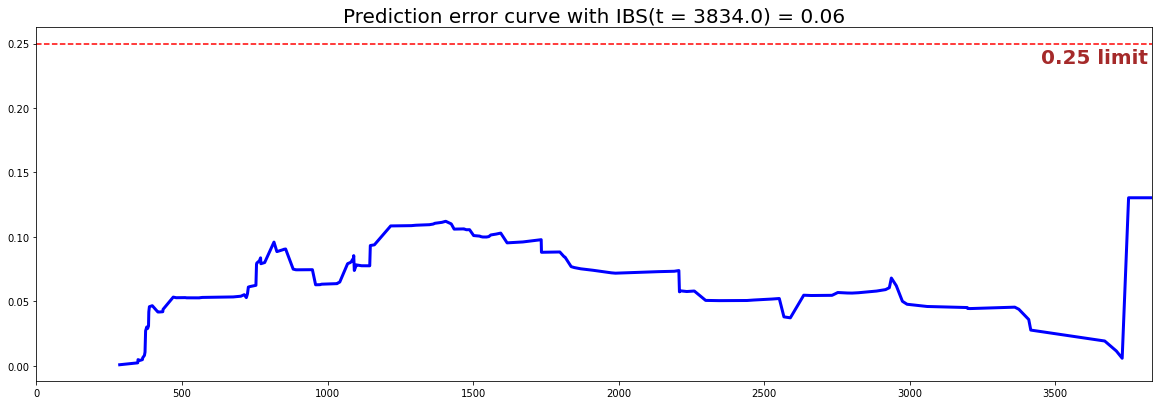

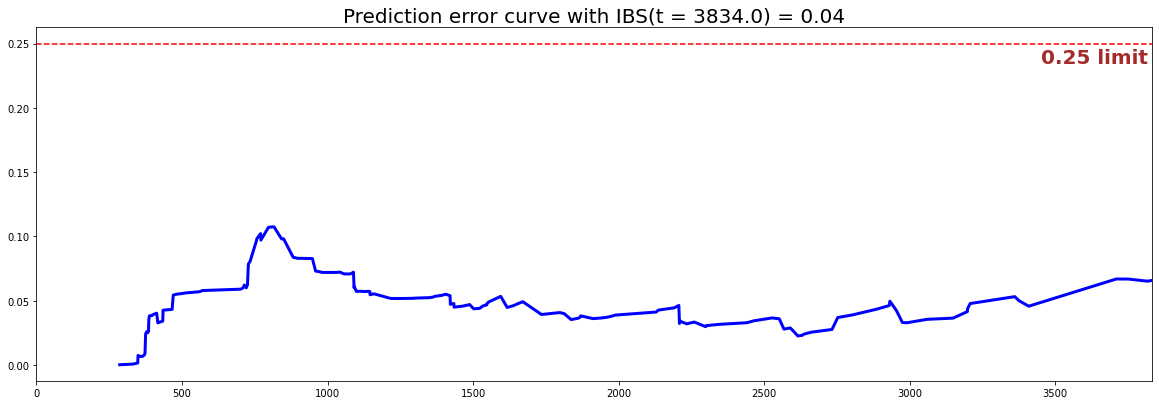

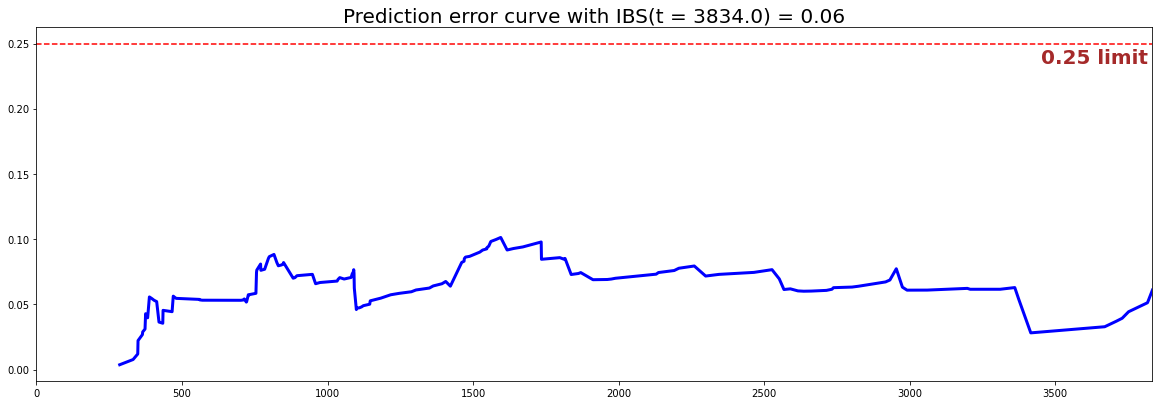

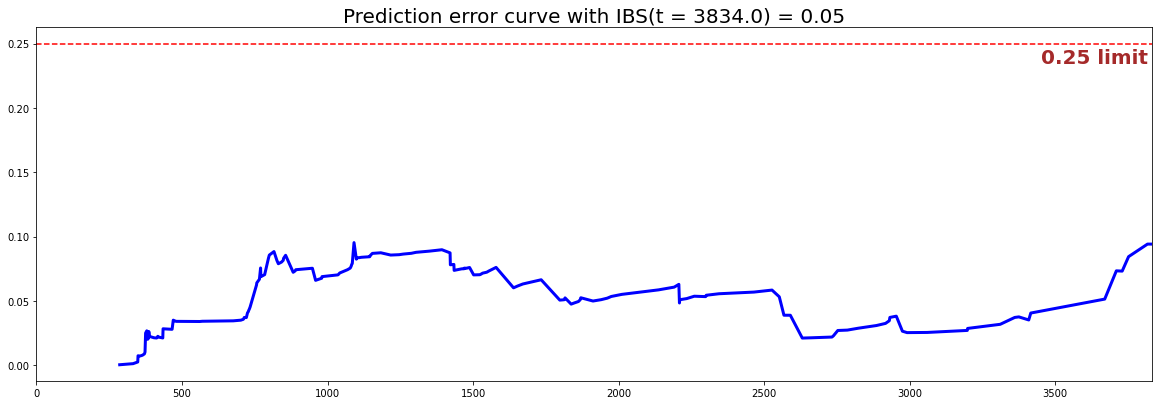

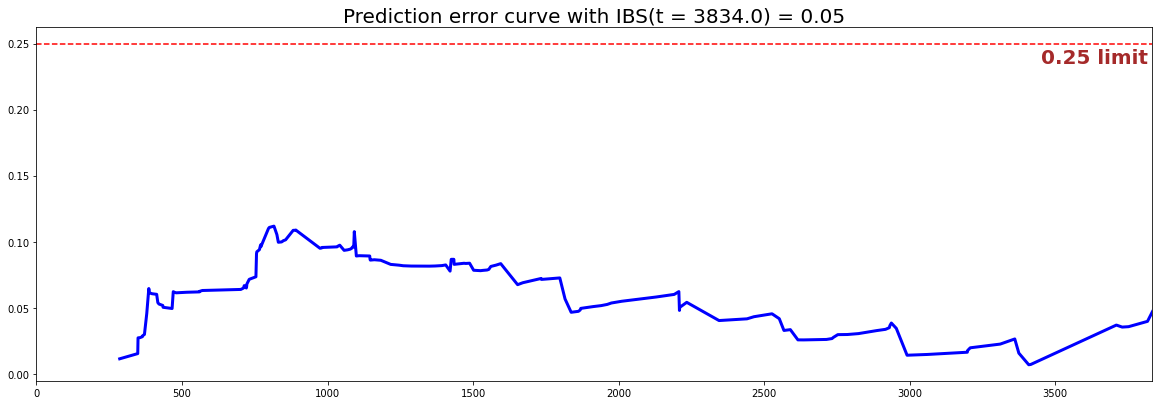

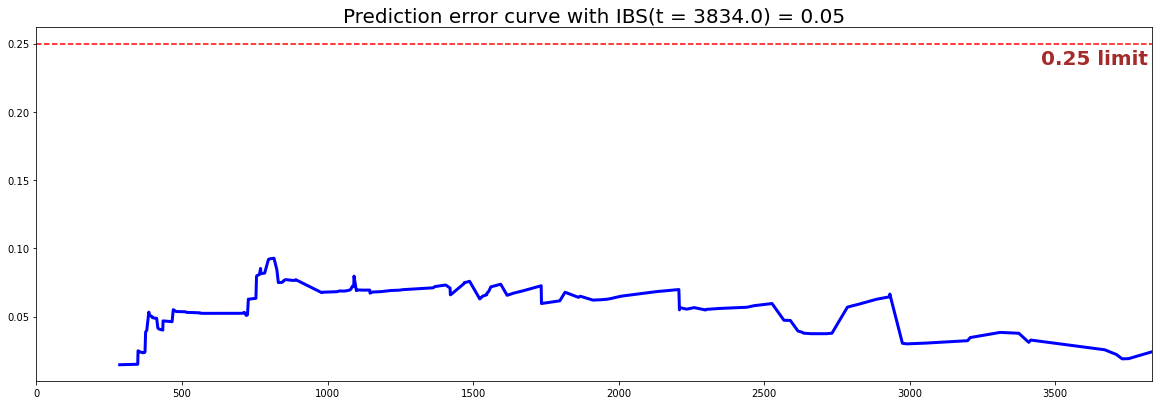

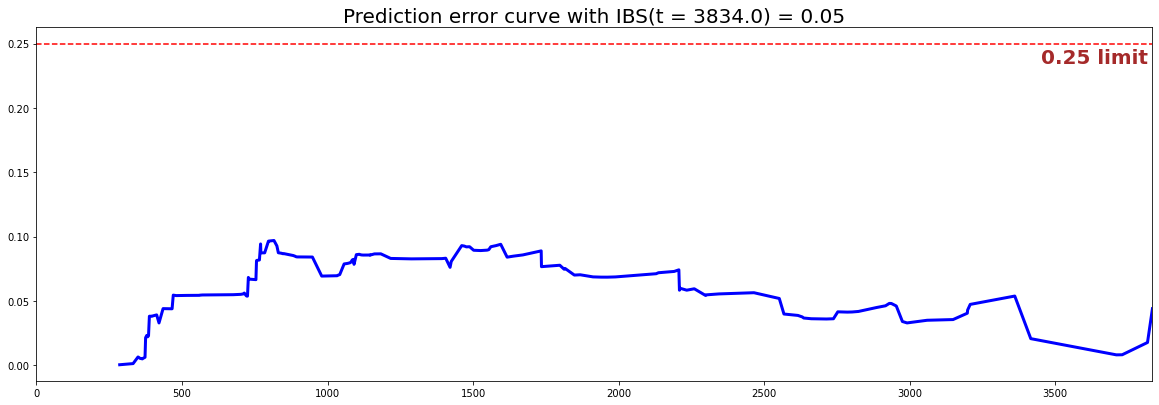

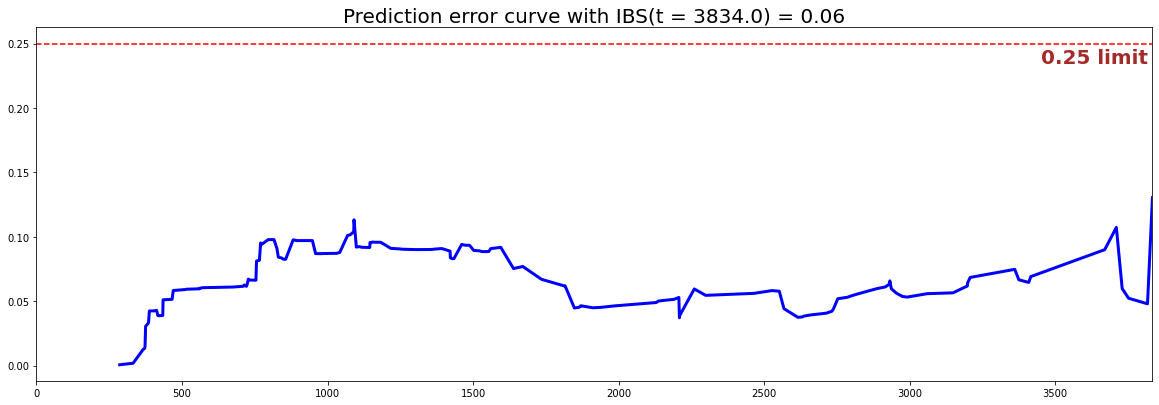

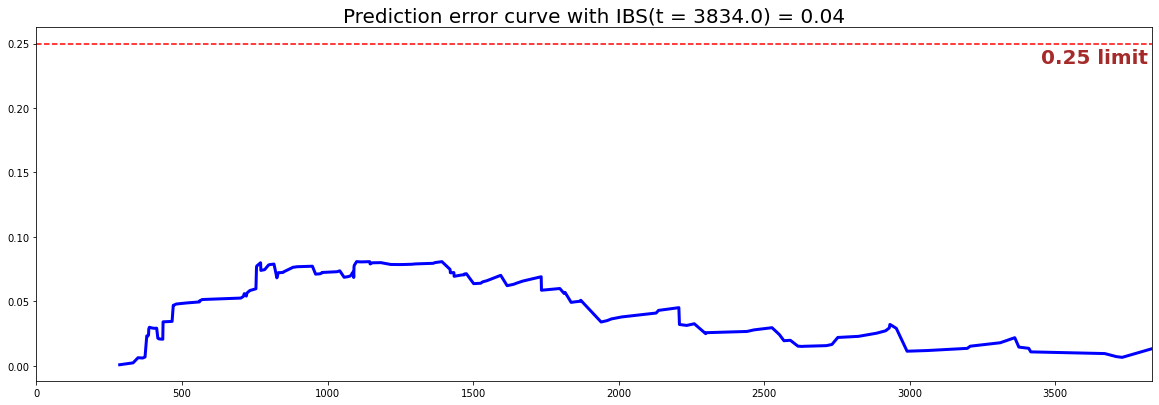

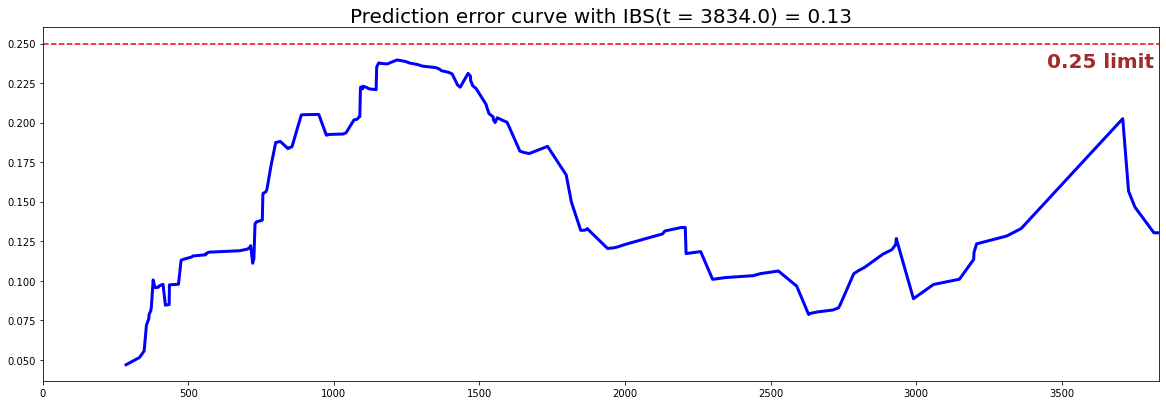

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.8895270552496928, 0.9214477144303862, 0.9051427980599241, 0.9154586445396241, 0.9043252777603712, 0.9130383115914429, 0.9011705944325338, 0.8831449995006863, 0.9300655937990495, 0.75455519991038]
0.8917876189274091
0.04763713865643037
[0.05910055624618092, 0.044473090543409255, 0.05809386293587854, 0.04798572954604086, 0.048288710834229, 0.04911255096354826, 0.05153983898799467, 0.060820865600667545, 0.03664900900299002, 0.1343821196304705]
0.05904463342914096
0.026051199977992406


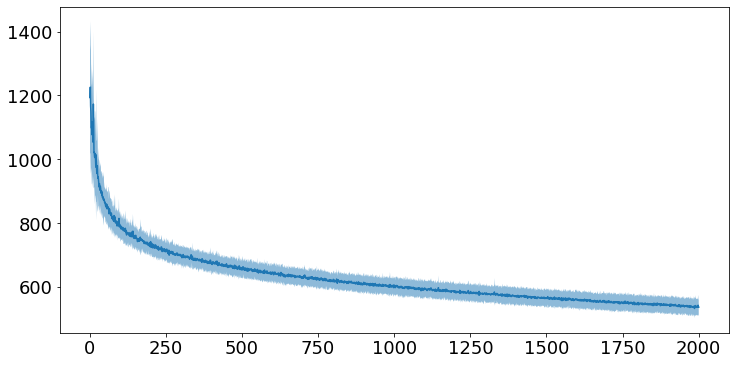

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

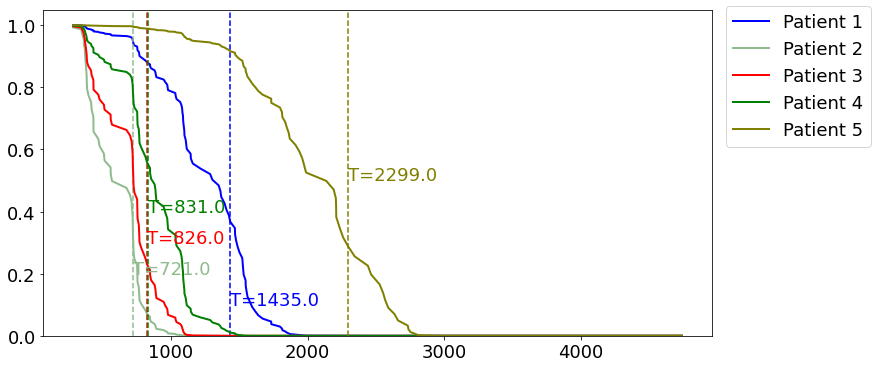

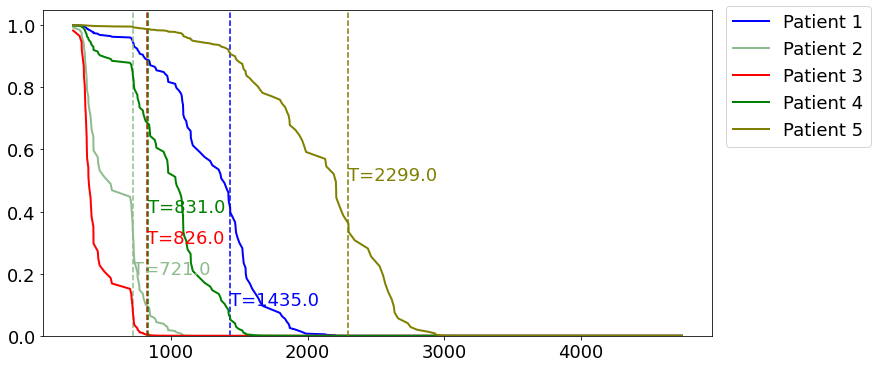

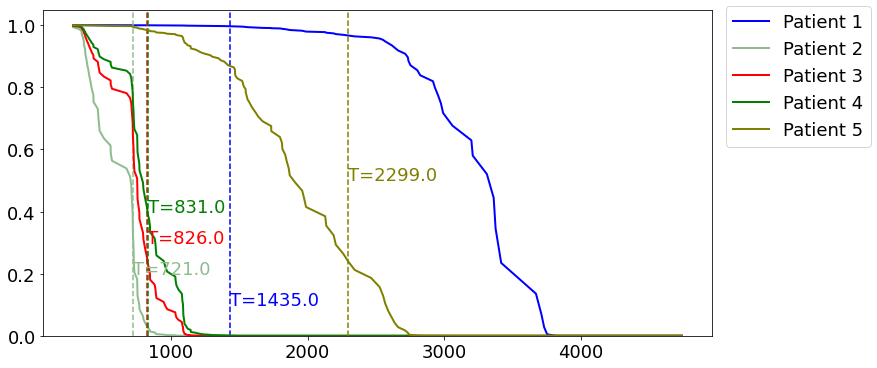

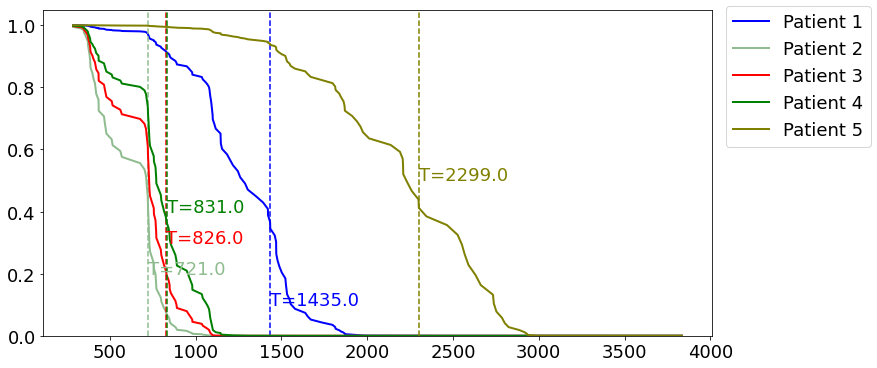

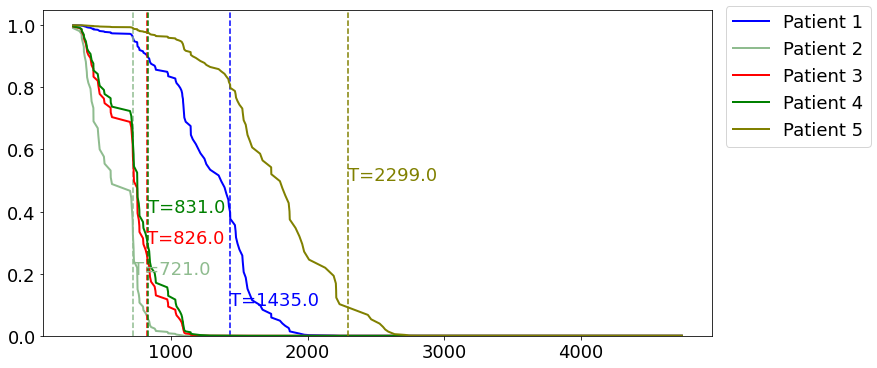

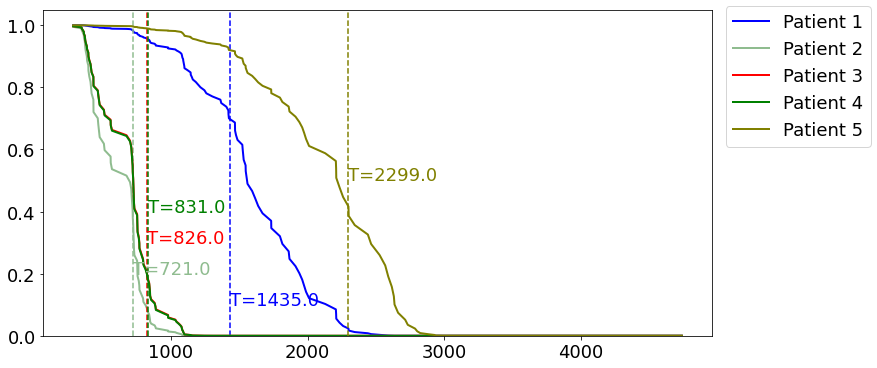

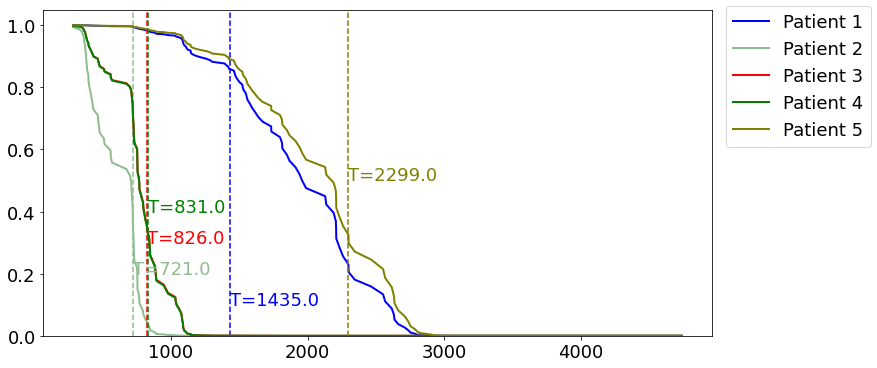

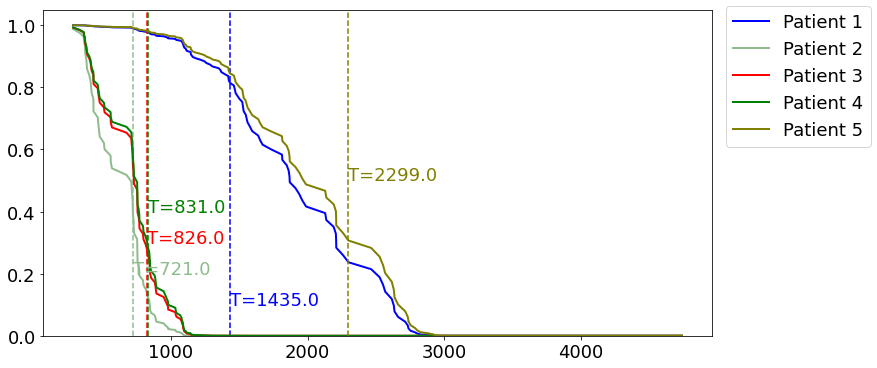

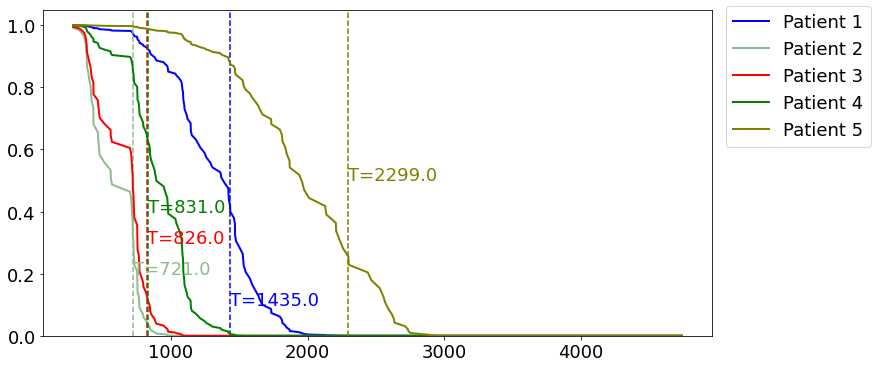

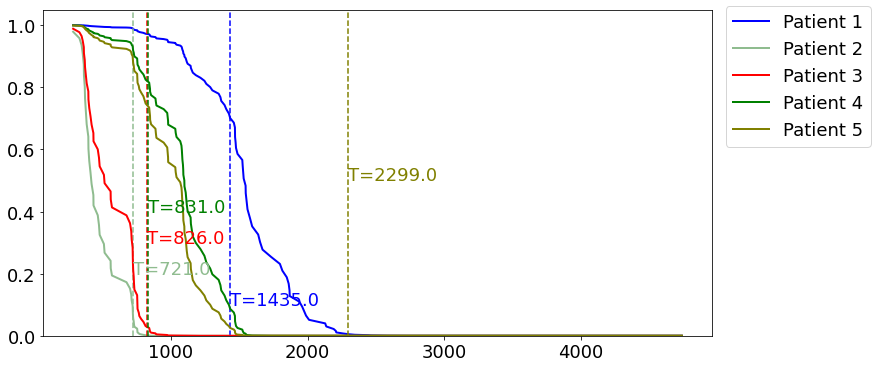

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

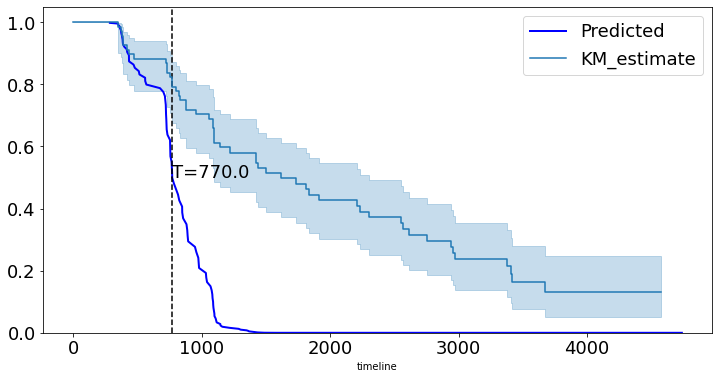

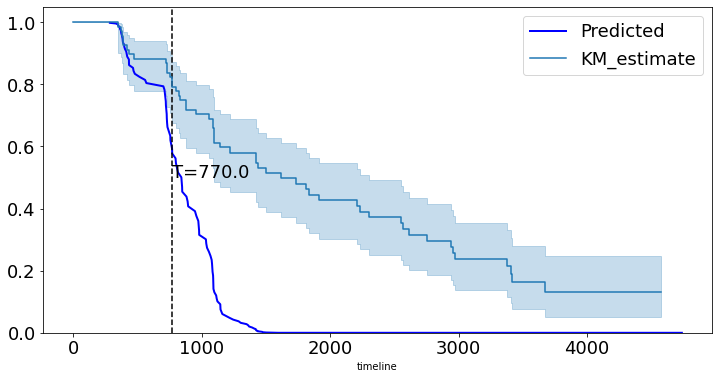

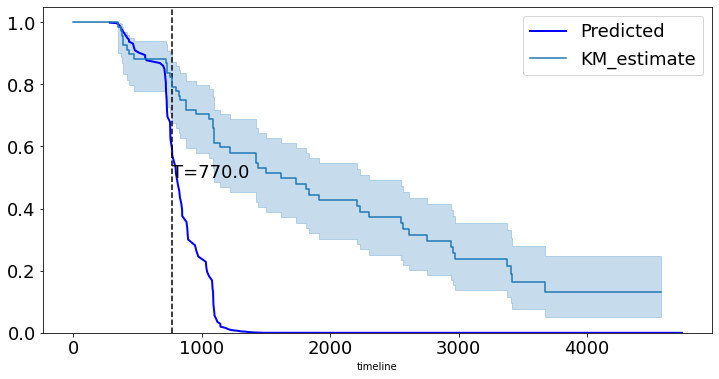

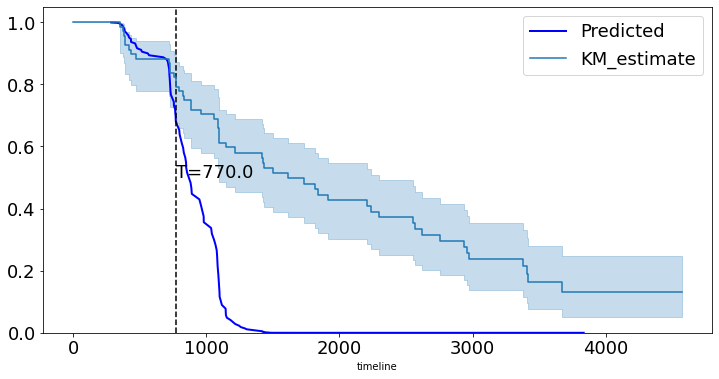

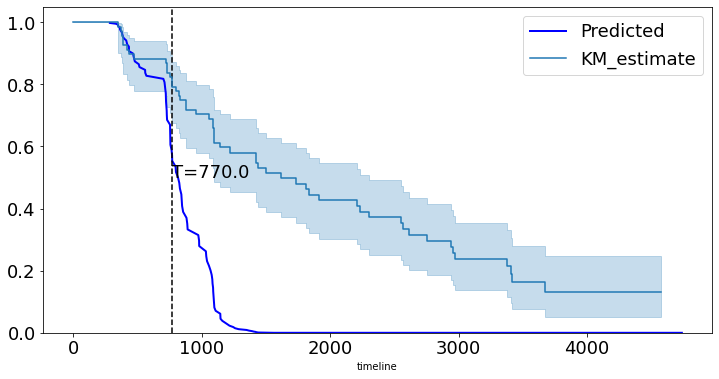

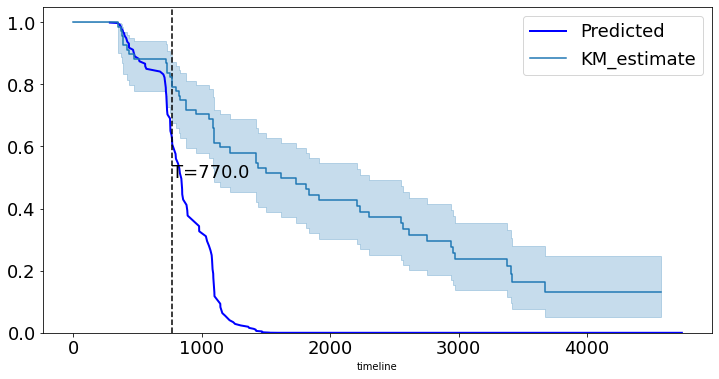

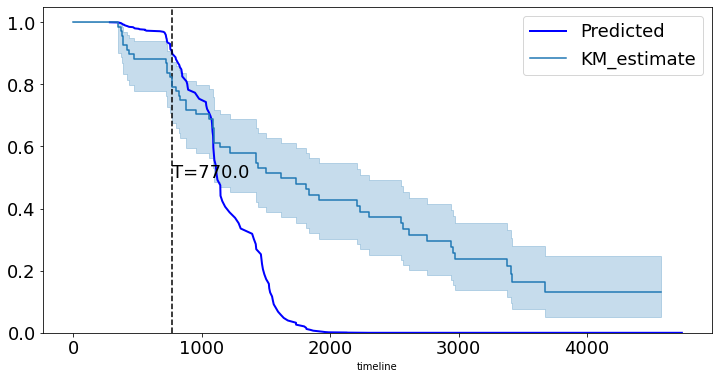

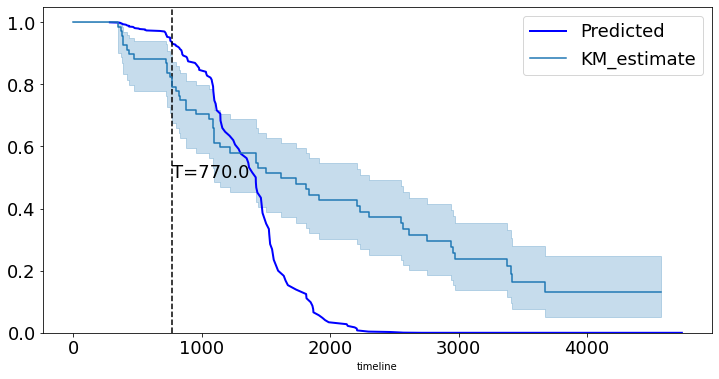

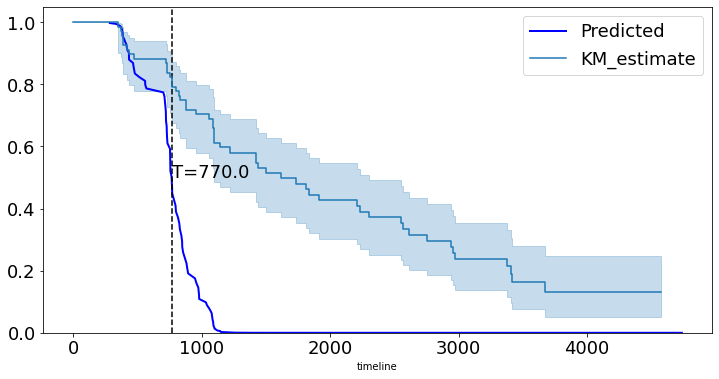

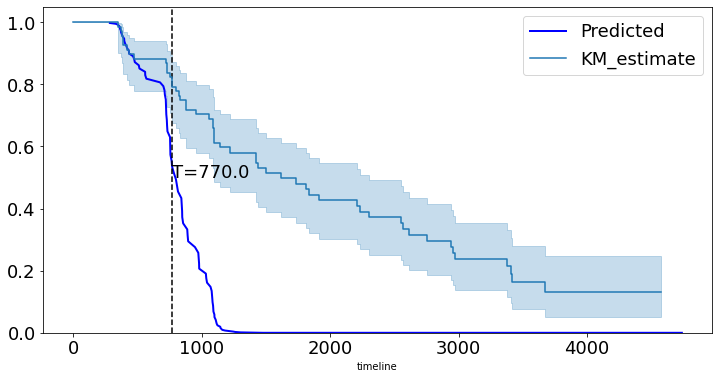

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

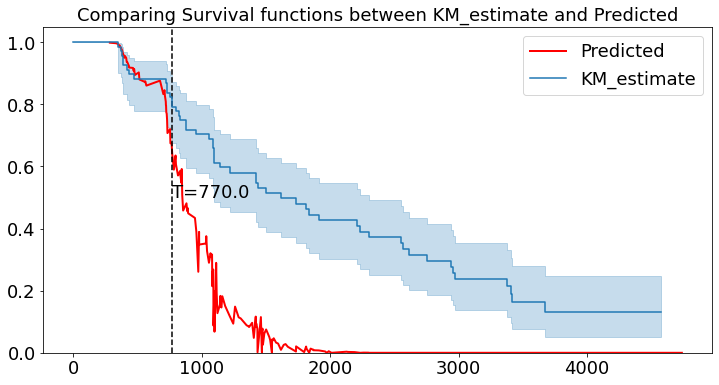

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=243, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[105,
 22,
 109,
 108,
 59,
 67,
 214,
 112,
 20,
 126,
 38,
 241,
 15,
 242,
 175,
 25,
 211,
 174,
 52,
 191,
 13,
 61,
 27,
 4,
 226,
 23,
 113,
 233,
 137,
 49,
 11,
 236,
 146,
 195,
 129,
 34,
 54,
 51,
 139,
 16,
 196,
 14,
 91,
 46,
 131,
 31,
 123,
 147,
 40,
 121,
 42,
 120,
 21,
 111,
 2,
 118,
 69,
 127,
 60,
 53,
 231,
 6,
 7,
 212,
 189,
 234,
 170,
 192,
 3,
 101,
 24,
 151,
 154,
 26,
 44,
 104,
 125,
 1,
 72,
 197,
 90,
 28,
 0,
 132,
 150,
 159,
 56,
 161,
 65,
 162,
 12,
 141,
 64,
 183,
 155,
 32,
 163,
 133,
 187,
 157]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([16.120998 , 12.61292  , 12.533147 , 11.846941 , 11.245655 ,
       10.981831 , 10.57739  , 10.286419 , 10.122469 , 10.121734 ,
       10.003768 ,  9.961748 ,  9.945139 ,  9.897852 ,  9.855883 ,
        9.849515 ,  9.849348 ,  9.797374 ,  9.793527 ,  9.778528 ,
        9.740728 ,  9.733232 ,  9.724693 ,  9.707657 ,  9.700594 ,
        9.695978 ,  9.684415 ,  9.64788  ,  9.642384 ,  9.630809 ,
        9.620096 ,  9.594325 ,  9.586386 ,  9.585046 ,  9.584708 ,
        9.581945 ,  9.581186 ,  9.579369 ,  9.578576 ,  9.571665 ,
        9.571413 ,  9.543901 ,  9.531739 ,  9.527682 ,  9.522272 ,
        9.512994 ,  9.510614 ,  9.505673 ,  9.504247 ,  9.502212 ,
        9.498487 ,  9.484258 ,  9.468786 ,  9.467313 ,  9.466055 ,
        9.466024 ,  9.457845 ,  9.453241 ,  9.441824 ,  9.425234 ,
        9.419427 ,  9.417968 ,  9.410532 ,  9.399612 ,  9.397906 ,
        9.388367 ,  9.383265 ,  9.38265  ,  9.370325 ,  9.365787 ,
        9.365576 ,  9.364873 ,  9.3611555,  9.357713 ,  9.3576

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'COMMUN', 'NACCAGE', 'NACCIDEM', 'NACCPPA', 'NACCMCII',
       'NPTDPD', 'NACCNE4S', 'ORIENT', 'NPASAN', 'BEDEP', 'NACCDAGE',
       'RESIDENC', 'NACCINT', 'NPWMR', 'CDRSUM', 'NPTDPA', 'NACCARTE',
       'MOSLOW', 'NPHIPSCL', 'NACCLIVS', 'NACCLBDS', 'DECIN', 'SEX',
       'NPPDXK', 'HOMEHOBB', 'NPPMIH', 'NACCOTHP', 'NACCDIFF', 'MOGAIT',
       'EDUC', 'NACCFORM', 'NPINF2B', 'NACCCBD', 'NPHISG', 'NACCCOGF',
       'MOMODE', 'MOTREM', 'NACCAMY', 'HANDED', 'NACCPROG', 'INDEPEND',
       'DEPIF', 'BEOTHR', 'NPHIST', 'COGVIS', 'NACCAVAS', 'NPINF2D',
       'BEAHALL', 'NPGRSNH', 'BEDISIN', 'NPGRHA', 'JUDGMENT', 'NACCAPOE',
       'BIRTHMO', 'NPGRCCA', 'NACCALZD', 'NPTDPAN', 'NACCBVFT',
       'NACCMOTF', 'NPPDXP', 'HISPOR', 'RACE', 'NPTDPB', 'NPLBOD',
       'NACCBNKF', 'NPOLDD2', 'NPFTDTAU', 'BIRTHYR', 'COGOTHIF',
       'PERSCARE', 'NPINF3D', 'NPINF4B', 'DECSUB', 'BEAGIT', 'NACCFTDM',
       'NPABAN', 'NACCREFR', 'NACCLBDP', 'NPFTDT5', 'DEP', 'COGMEM',
       'NACCREAS',

In [22]:
np.array(column_names[:-2]).shape

(243,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(243, 150)

In [25]:
first_layer_weight

array([[ 0.01220227, -0.00295503, -0.01068822, ...,  0.03208402,
        -0.03394639, -0.02003256],
       [-0.00690608,  0.00085231,  0.02076606, ...,  0.00805814,
         0.02522096, -0.00211282],
       [-0.00440496,  0.04392462, -0.02892015, ..., -0.0216055 ,
         0.02261448,  0.01632468],
       ...,
       [-0.0214019 , -0.01871175, -0.017987  , ..., -0.0255796 ,
        -0.00100192, -0.00161698],
       [-0.00852799,  0.00275878,  0.0386015 , ..., -0.02971426,
        -0.06082591, -0.02916742],
       [-0.01470556,  0.05672966, -0.02402688, ...,  0.05787368,
        -0.01246913,  0.00134603]], dtype=float32)

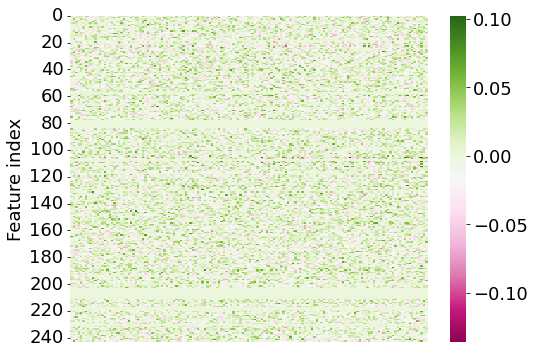

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

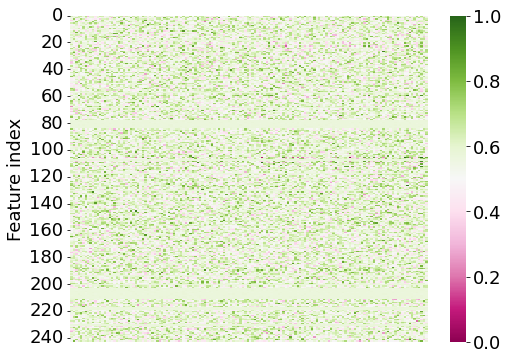

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()